<a href="https://colab.research.google.com/github/aditya-465/aditya-dwi-putro-wicaksono/blob/master/Tesis241193_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 11QayMlwNWZV8CUSj4Wy37OYTq_-slXIk

Downloading...
From: https://drive.google.com/uc?id=11QayMlwNWZV8CUSj4Wy37OYTq_-slXIk
To: /content/dataset.zip
100% 476M/476M [00:03<00:00, 125MB/s]


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: Dataset 1 Test Tunggal/
  inflating: Dataset 1 Test Tunggal/SCB-10.jpg  
  inflating: Dataset 1 Test Tunggal/SCTB+10.jpg  
  inflating: Dataset 1 Test Tunggal/PCB-10.jpg  
  inflating: Dataset 1 Test Tunggal/SCB+10.jpg  
  inflating: Dataset 1 Test Tunggal/PCTB-10.jpg  
  inflating: Dataset 1 Test Tunggal/SCTB-10.jpg  
  inflating: Dataset 1 Test Tunggal/PCB+10.jpg  
  inflating: Dataset 1 Test Tunggal/PCTB+10.jpg  
   creating: Dataset 1 Train Group/
   creating: Dataset 1 Train Group/Sore,CB,Mentah/
  inflating: Dataset 1 Train Group/Sore,CB,Mentah/SCB-10.jpg  
  inflating: Dataset 1 Train Group/Sore,CB,Mentah/SCB-6.jpg  
  inflating: Dataset 1 Train Group/Sore,CB,Mentah/SCB-4.jpg  
  inflating: Dataset 1 Train Group/Sore,CB,Mentah/SCB-1.jpg  
  inflating: Dataset 1 Train Group/Sore,CB,Mentah/SCB-5.jpg  
  inflating: Dataset 1 Train Group/Sore,CB,Mentah/SCB-7.jpg  
  inflating: Dataset 1 Train Group/Sore,CB,Mentah/SCB-3.jpg  
  inflating: Dataset 1 

In [ ]:
!mv "/content/Dataset 2 - Train Group/Pagi,CB, Mentah" "/content/Dataset 2 - Train Group/Pagi,CB,Mentah"

In [ ]:
!rm dataset.zip

In [ ]:
import os
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

import cv2
import PIL
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
default_size = tuple((255,400))
train_folder = 'Dataset 2 - Train Group'
test_folder = 'Dataset 2 - Test Tunggal'

In [ ]:
def crop_resize(img_path):
  img = cv2.imread(img_path)
  h0 = img.shape[0]
  w0 = img.shape[1]
  if h0 == 4000:
    const = 10
  else:
    const = 5.6
  h = int(default_size[1]*const)
  w = int(default_size[0]*const)
  img = img[int((h0-h)/2):int((h0-h)/2)+h,int((w0-w)/2):int((w0-w)/2)+w]
  return cv2.resize(img,default_size)

In [ ]:
def crop_resize_x(img_path):
  img = PIL.Image.open(img_path)
  img = img.rotate(-90)
  img = PIL.ImageEnhance.Color(img).enhance(2)
  h0 = img.size[1]
  w0 = img.size[0]
  if w0 == 4000:
    const = 10
  else:
    const = 5.6
  w = int(default_size[1]*const)
  h = int(default_size[0]*const)
  ch = (h0-h)/2
  cw = (w0-w)/2
  img = img.crop((cw,ch,w0-cw,h0-ch))
  return np.array(img.resize((255,400)))

In [ ]:
def augmentation(input_images,input_labels,dup):
  augmented = []
  labels = []
  for j in tqdm(range(len(input_images))):
      samples = np.expand_dims(input_images[j], 0)
      datagen = ImageDataGenerator(width_shift_range=[-20,20])
      it = datagen.flow(samples, batch_size=1)
      for i in range(dup):
          batch = it.next()
          image = batch[0].astype('uint8')
          augmented.append(image)
          labels.append(input_labels[j])
  input_images = input_images + augmented
  input_labels = input_labels + labels
  return input_images,input_labels

In [ ]:
def brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
opt = sorted(set([n[:-7] for n in (sorted(os.listdir(train_folder)))]))
opt

['Pagi,CB', 'Pagi,CTB', 'Sore,CB', 'Sore,CTB']

In [ ]:
ix_col = ['Filename','Mean Blue','Mean Green','Mean Red','Std. Blue','Std. Green','Std. Red']

In [ ]:
def generate_data(option,dup):
  ori_train_images = []
  ori_train_labels = []
  train_filename = []
  train_images = []
  train_labels = []
  for label in tqdm(sorted(os.listdir(train_folder))):
    if label.startswith(option):
      folder = os.path.join(train_folder,label)
      for files in sorted(os.listdir(folder)):
        image = os.path.join(folder,files)
        ori_train_images.append(cv2.imread(image))
        ori_train_labels.append(label)
        image = crop_resize(image)
        train_images.append(image)
        train_images.append(cv2.flip(image, 1))
        train_labels.append(label)
        train_labels.append(label)
        train_filename.append(os.path.join(folder,files))
        train_filename.append(os.path.join(folder,files))
  ix1n = np.array(train_images).mean(1).mean(1).tolist()
  ix2n = np.array(train_images).std(1).std(1).tolist()
  train_fe = []
  for n in range(len(ix1n)):
    train_fe.append([train_filename[n]]+ix1n[n]+ix2n[n])
  train_fe_df = pd.DataFrame(train_fe,columns=ix_col)
  ori_test_images = []
  ori_test_labels = []
  test_filename = []
  test_images = []
  test_labels = []
  for files in tqdm(sorted(os.listdir(test_folder))):
    if files.startswith("P"):
      label1 = "Pagi"
    else:
      label1 = "Sore"
    if files.endswith("+.jpg"):
      label2 = "Matang"
    else:
      label2 = "Mentah"
    label = label1 + ',' + files[1:-5] + ',' + label2
    if label.startswith(option):
      ori_test_images.append(cv2.imread(os.path.join(test_folder,files)))
      ori_test_labels.append(label)
      image = crop_resize(os.path.join(test_folder,files))
      test_images.append(image)
      test_images.append(cv2.flip(image, 1))
      test_labels.append(label)
      test_labels.append(label)
      test_filename.append(os.path.join(test_folder,files))
      test_filename.append(os.path.join(test_folder,files))
  ix1t = np.array(test_images).mean(1).mean(1).tolist()
  ix2t = np.array(test_images).std(1).std(1).tolist()
  test_fe = []
  for n in range(len(ix1t)):
    test_fe.append([test_filename[n]]+ix1t[n]+ix2t[n])
  test_fe_df = pd.DataFrame(test_fe,columns=ix_col)
  print("Original train data       :", int(len(train_images)/2))
  print("Original test data        :", int(len(test_images)/2))
  print("Augmentation I train data :", int(len(train_images)))
  print("Augmentation I test data  :", int(len(test_images)))
  train_images,train_labels = augmentation(train_images,train_labels,dup)
  test_images,test_labels = augmentation(test_images,test_labels,dup)
  print()
  print("Augmentation II train data :", int(len(train_images)))
  print("Augmentation II test data  :", int(len(test_images)))
  return train_images,test_images,train_labels,test_labels,ori_train_images,ori_test_images,ori_train_labels,ori_test_labels,train_fe_df,test_fe_df

In [ ]:
print(opt[0])
train_images,test_images,train_labels,test_labels,ori_train_images,ori_test_images,ori_train_labels,ori_test_labels,train_fe_df,test_fe_df = generate_data(opt[0],9)

Pagi,CB


100%|██████████| 8/8 [00:01<00:00,  7.90it/s]


Original train data       : 20
Original test data        : 2
Augmentation I train data : 40
Augmentation I test data  : 4


100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


Augmentation II train data : 400
Augmentation II test data  : 40


In [ ]:
train_fe_df

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red
0,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",153.270971,187.684657,181.466922,7.594769,6.341900,6.192601
1,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",153.270971,187.684657,181.466922,7.594769,6.341900,6.192601
2,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",68.463373,140.583265,130.796735,15.195229,5.943402,6.073097
3,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",68.463373,140.583265,130.796735,15.195229,5.943402,6.073097
4,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",71.951598,141.570863,131.814137,17.680457,9.768730,10.319633
5,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",71.951598,141.570863,131.814137,17.680457,9.768730,10.319633
6,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",69.337755,136.463990,120.017696,19.324326,7.422741,8.144091
7,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",69.337755,136.463990,120.017696,19.324326,7.422741,8.144091
8,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",56.511392,131.952539,116.653500,18.659054,9.230256,8.039185
9,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",56.511392,131.952539,116.653500,18.659054,9.230256,8.039185


In [ ]:
test_fe_df

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red
0,Dataset 2 - Test Tunggal/PCB+.jpg,68.463373,140.583265,130.796735,15.195229,5.943402,6.073097
1,Dataset 2 - Test Tunggal/PCB+.jpg,68.463373,140.583265,130.796735,15.195229,5.943402,6.073097
2,Dataset 2 - Test Tunggal/PCB-.jpg,64.227951,124.644284,109.133647,15.933372,8.803147,9.515347
3,Dataset 2 - Test Tunggal/PCB-.jpg,64.227951,124.644284,109.133647,15.933372,8.803147,9.515347


In [ ]:
ix = []
for n in range(len(ix1)):
  ix.append(ix1[n]+ix2[n])

In [ ]:
pd.DataFrame(ix,columns=ix_col)

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red


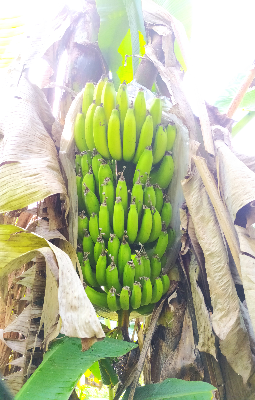

In [ ]:
imshow(train_images[0])

In [ ]:
le = LabelEncoder()
x_train = np.array(train_images)/255
y_train = le.fit_transform(train_labels)
x_test = np.array(test_images)/255
y_test = le.fit_transform(test_labels)
le.classes_

array(['Pagi,CB,Matang', 'Pagi,CB,Mentah'], dtype='<U14')

In [ ]:
model = Sequential([Flatten(input_shape = [default_size[1], default_size[0], 3]),
Dense(300, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(2, activation = 'softmax' )])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 306000)            0         
                                                                 
 dense (Dense)               (None, 300)               91800300  
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 2)                 202       
                                                                 
Total params: 91,850,802
Trainable params: 91,850,802
No

In [ ]:
# compile model
model.compile(loss = 'sparse_categorical_crossentropy',\
    optimizer = 'sgd',\
    metrics = ['accuracy'])

In [ ]:
# training model
epoch = 50

history = model.fit(x_train,
                    y_train,
                    epochs = epoch,
                    # validation_split=0.5
                )

Epoch 1/50
13/13 [==============================] - 2s 31ms/step - loss: 1.7646 - accuracy: 0.5150
Epoch 2/50
13/13 [==============================] - 0s 29ms/step - loss: 0.7370 - accuracy: 0.5050
Epoch 3/50
13/13 [==============================] - 0s 29ms/step - loss: 0.6485 - accuracy: 0.6025
Epoch 4/50
13/13 [==============================] - 0s 28ms/step - loss: 0.5508 - accuracy: 0.7750
Epoch 5/50
13/13 [==============================] - 0s 28ms/step - loss: 0.6463 - accuracy: 0.6500
Epoch 6/50
13/13 [==============================] - 0s 29ms/step - loss: 0.5545 - accuracy: 0.7475
Epoch 7/50
13/13 [==============================] - 0s 29ms/step - loss: 0.3936 - accuracy: 0.8600
Epoch 8/50
13/13 [==============================] - 0s 28ms/step - loss: 0.2806 - accuracy: 0.8900
Epoch 9/50
13/13 [==============================] - 0s 28ms/step - loss: 0.1965 - accuracy: 0.9500
Epoch 10/50
13/13 [==============================] - 0s 28ms/step - loss: 0.0242 - accuracy: 1.0000
Epoch 11/

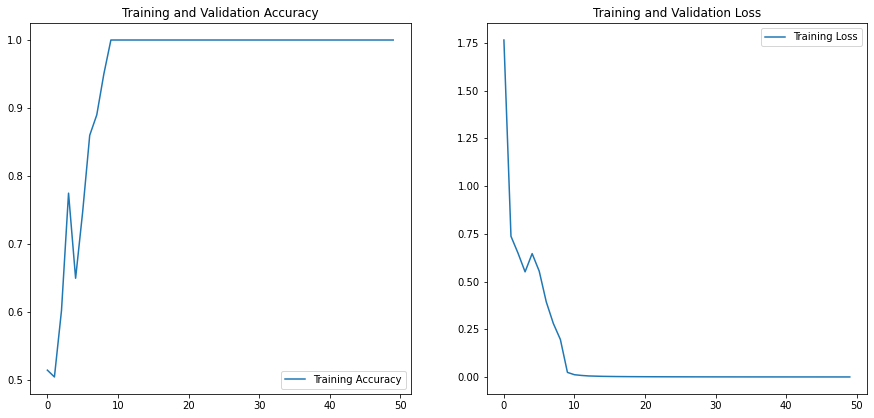

In [ ]:
# Kurva akurasi training
# membuat variabel tiap kategori matrics hasil training, baik data training ataupun validasi
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']

# membuat range epoch untuk X axis
epochs_range = range(epoch)

plt.figure(figsize=(15, 15))                                                                  # setup ukuran gambar
plt.subplot(2, 2, 1)                                                                          # subplot posisi pertama
plt.plot(epochs_range, acc, label='Training Accuracy')                                        # line chart training accuracy
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')                                  # line chart validation accuracy
plt.legend(loc='lower right')                                                                 # lokasi legend
plt.title('Training and Validation Accuracy')                                                 # judul chart

plt.subplot(2, 2, 2)                                                                          # sublplot posisi pertama
plt.plot(epochs_range, loss, label='Training Loss')                                           # linechart training loss
# plt.plot(epochs_range, val_loss, label='Validation Loss')                                     # linechart validation loss
plt.legend(loc='upper right')                                                                 # posisi legend
plt.title('Training and Validation Loss')                                                     # judul chart
plt.show()

In [ ]:
loss,accuracy = model.evaluate(x_train,y_train, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  1.0
Model loss     :  0.0003455202386248857


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  1.0
Model loss     :  0.0006349693285301328


In [ ]:
pred_ann = model.predict(x_train)
pred_ann = np.argmax(pred_ann, axis=-1) 
print(classification_report(y_train,pred_ann, target_names=le.classes_))

                precision    recall  f1-score   support

Pagi,CB,Matang       1.00      1.00      1.00       200
Pagi,CB,Mentah       1.00      1.00      1.00       200

      accuracy                           1.00       400
     macro avg       1.00      1.00      1.00       400
  weighted avg       1.00      1.00      1.00       400



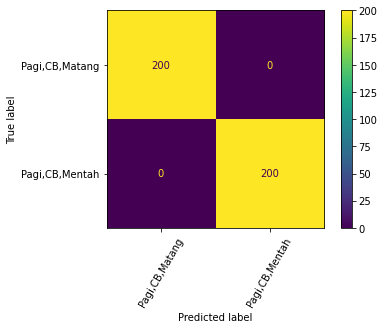

In [ ]:
cm = confusion_matrix(y_train, pred_ann)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.xticks(rotation=60)
plt.show() 

In [ ]:
pred_ann = model.predict(x_test)
pred_ann = np.argmax(pred_ann, axis=-1) 
print(classification_report(y_test,pred_ann, target_names=le.classes_))

                precision    recall  f1-score   support

Pagi,CB,Matang       1.00      1.00      1.00        20
Pagi,CB,Mentah       1.00      1.00      1.00        20

      accuracy                           1.00        40
     macro avg       1.00      1.00      1.00        40
  weighted avg       1.00      1.00      1.00        40



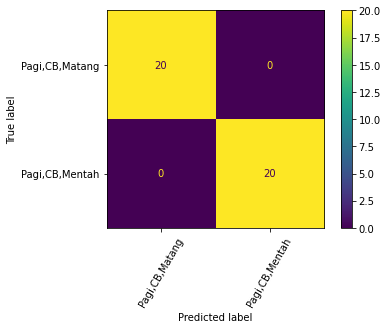

In [ ]:
cm = confusion_matrix(y_test, pred_ann)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.xticks(rotation=60)
plt.show() 

In [ ]:
print(opt[1])
train_images,test_images,train_labels,test_labels,ori_train_images,ori_test_images,ori_train_labels,ori_test_labels,train_fe_df,test_fe_df = generate_data(opt[1],9)

Pagi,CTB


100%|██████████| 8/8 [00:00<00:00, 27.21it/s]


Original train data       : 20
Original test data        : 2
Augmentation I train data : 40
Augmentation I test data  : 4


100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


Augmentation II train data : 400
Augmentation II test data  : 40


In [ ]:
train_fe_df

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red
0,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",153.270971,187.684657,181.466922,7.594769,6.341900,6.192601
1,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",153.270971,187.684657,181.466922,7.594769,6.341900,6.192601
2,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",68.463373,140.583265,130.796735,15.195229,5.943402,6.073097
3,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",68.463373,140.583265,130.796735,15.195229,5.943402,6.073097
4,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",71.951598,141.570863,131.814137,17.680457,9.768730,10.319633
5,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",71.951598,141.570863,131.814137,17.680457,9.768730,10.319633
6,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",69.337755,136.463990,120.017696,19.324326,7.422741,8.144091
7,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",69.337755,136.463990,120.017696,19.324326,7.422741,8.144091
8,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",56.511392,131.952539,116.653500,18.659054,9.230256,8.039185
9,"Dataset 2 - Train Group/Pagi,CB,Matang/IMG_202...",56.511392,131.952539,116.653500,18.659054,9.230256,8.039185


In [ ]:
test_fe_df

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red
0,Dataset 2 - Test Tunggal/PCTB+.jpg,116.073510,132.099010,129.846039,7.980656,5.823246,6.108404
1,Dataset 2 - Test Tunggal/PCTB+.jpg,116.073510,132.099010,129.846039,7.980656,5.823246,6.108404
2,Dataset 2 - Test Tunggal/PCTB-.jpg,121.085755,126.922422,129.218922,14.608575,12.788527,10.330101
3,Dataset 2 - Test Tunggal/PCTB-.jpg,121.085755,126.922422,129.218922,14.608575,12.788527,10.330101


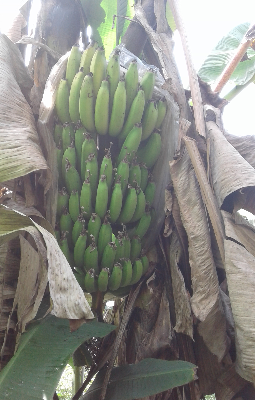

In [ ]:
imshow(train_images[0])

In [ ]:
le = LabelEncoder()
x_train = np.array(train_images)/255
y_train = le.fit_transform(train_labels)
x_test = np.array(test_images)/255
y_test = le.fit_transform(test_labels)
le.classes_

array(['Pagi,CTB,Matang', 'Pagi,CTB,Mentah'], dtype='<U15')

In [ ]:
model = Sequential([Flatten(input_shape = [default_size[1], default_size[0], 3]),
Dense(300, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(2, activation = 'softmax' )])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 306000)            0         
                                                                 
 dense_5 (Dense)             (None, 300)               91800300  
                                                                 
 dense_6 (Dense)             (None, 100)               30100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 91,850,802
Trainable params: 91,850,802


In [ ]:
# compile model
model.compile(loss = 'sparse_categorical_crossentropy',\
    optimizer = 'sgd',\
    metrics = ['accuracy'])

In [ ]:
# training model
epoch = 5

history = model.fit(x_train,
                    y_train,
                    epochs = epoch,
                    # validation_split=0.5
                )

Epoch 1/5
13/13 [==============================] - 1s 29ms/step - loss: 2.7923 - accuracy: 0.5200
Epoch 2/5
13/13 [==============================] - 0s 28ms/step - loss: 0.6518 - accuracy: 0.6300
Epoch 3/5
13/13 [==============================] - 0s 28ms/step - loss: 0.6340 - accuracy: 0.6450
Epoch 4/5
13/13 [==============================] - 0s 29ms/step - loss: 0.5693 - accuracy: 0.7575
Epoch 5/5
13/13 [==============================] - 0s 27ms/step - loss: 0.5093 - accuracy: 0.8050


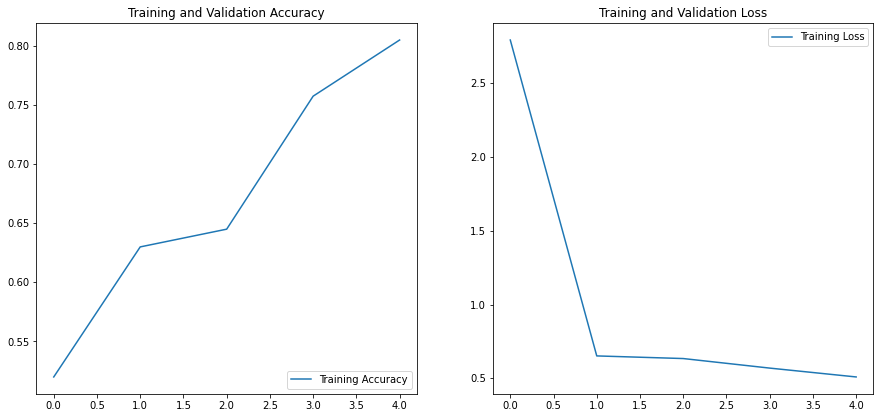

In [ ]:
# Kurva akurasi training
# membuat variabel tiap kategori matrics hasil training, baik data training ataupun validasi
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']

# membuat range epoch untuk X axis
epochs_range = range(epoch)

plt.figure(figsize=(15, 15))                                                                  # setup ukuran gambar
plt.subplot(2, 2, 1)                                                                          # subplot posisi pertama
plt.plot(epochs_range, acc, label='Training Accuracy')                                        # line chart training accuracy
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')                                  # line chart validation accuracy
plt.legend(loc='lower right')                                                                 # lokasi legend
plt.title('Training and Validation Accuracy')                                                 # judul chart

plt.subplot(2, 2, 2)                                                                          # sublplot posisi pertama
plt.plot(epochs_range, loss, label='Training Loss')                                           # linechart training loss
# plt.plot(epochs_range, val_loss, label='Validation Loss')                                     # linechart validation loss
plt.legend(loc='upper right')                                                                 # posisi legend
plt.title('Training and Validation Loss')                                                     # judul chart
plt.show()

In [ ]:
loss,accuracy = model.evaluate(x_train,y_train, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  0.5
Model loss     :  0.9009058475494385


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  0.5
Model loss     :  1.0091962814331055


In [ ]:
pred_ann = model.predict(x_train)
pred_ann = np.argmax(pred_ann, axis=-1) 
print(classification_report(y_train,pred_ann, target_names=le.classes_))

                 precision    recall  f1-score   support

Pagi,CTB,Matang       0.00      0.00      0.00       200
Pagi,CTB,Mentah       0.50      1.00      0.67       200

       accuracy                           0.50       400
      macro avg       0.25      0.50      0.33       400
   weighted avg       0.25      0.50      0.33       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


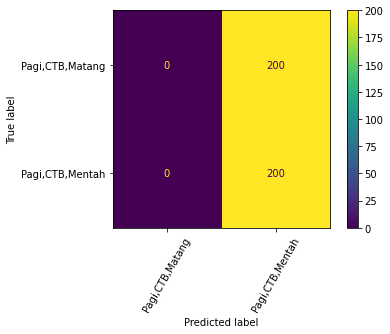

In [ ]:
cm = confusion_matrix(y_train, pred_ann)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.xticks(rotation=60)
plt.show() 

In [ ]:
pred_ann = model.predict(x_test)
pred_ann = np.argmax(pred_ann, axis=-1) 
print(classification_report(y_test,pred_ann, target_names=le.classes_))

                 precision    recall  f1-score   support

Pagi,CTB,Matang       0.00      0.00      0.00        20
Pagi,CTB,Mentah       0.50      1.00      0.67        20

       accuracy                           0.50        40
      macro avg       0.25      0.50      0.33        40
   weighted avg       0.25      0.50      0.33        40



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


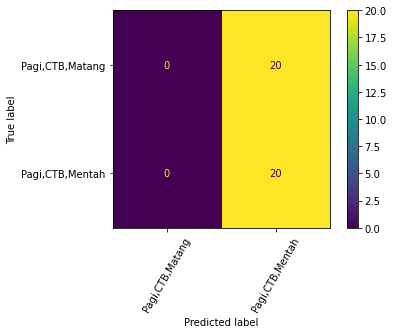

In [ ]:
cm = confusion_matrix(y_test, pred_ann)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.xticks(rotation=60)
plt.show() 

In [ ]:
print(opt[2])
train_images,test_images,train_labels,test_labels,ori_train_images,ori_test_images,ori_train_labels,ori_test_labels,train_fe_df,test_fe_df = generate_data(opt[2],9)

Sore,CB


100%|██████████| 8/8 [00:00<00:00,  8.03it/s]


Original train data       : 20
Original test data        : 2
Augmentation I train data : 40
Augmentation I test data  : 4


100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


Augmentation II train data : 400
Augmentation II test data  : 40


In [ ]:
train_fe_df

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red
0,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",104.306569,139.433225,129.626559,11.247365,7.598225,8.040021
1,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",104.306569,139.433225,129.626559,11.247365,7.598225,8.040021
2,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",101.187343,139.470931,129.921922,9.555785,6.414763,8.072023
3,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",101.187343,139.470931,129.921922,9.555785,6.414763,8.072023
4,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",97.049490,138.729578,128.194912,10.017369,6.742822,7.312376
5,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",97.049490,138.729578,128.194912,10.017369,6.742822,7.312376
6,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",98.100794,138.360441,129.044059,15.439213,8.761973,9.180071
7,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",98.100794,138.360441,129.044059,15.439213,8.761973,9.180071
8,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",97.316029,142.144088,131.306520,12.094993,6.589803,6.328566
9,"Dataset 2 - Train Group/Sore,CB,Matang/IMG_202...",97.316029,142.144088,131.306520,12.094993,6.589803,6.328566


In [ ]:
test_fe_df

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red
0,Dataset 2 - Test Tunggal/SCB+.jpg,87.650804,132.170775,120.956471,16.286393,9.723523,8.959503
1,Dataset 2 - Test Tunggal/SCB+.jpg,87.650804,132.170775,120.956471,16.286393,9.723523,8.959503
2,Dataset 2 - Test Tunggal/SCB-.jpg,85.855931,131.563196,110.781510,19.199758,11.229026,14.909244
3,Dataset 2 - Test Tunggal/SCB-.jpg,85.855931,131.563196,110.781510,19.199758,11.229026,14.909244


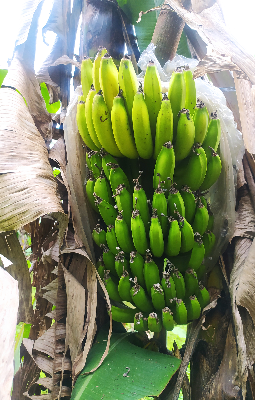

In [ ]:
imshow(train_images[0])

In [ ]:
le = LabelEncoder()
x_train = np.array(train_images)/255
y_train = le.fit_transform(train_labels)
x_test = np.array(test_images)/255
y_test = le.fit_transform(test_labels)
le.classes_

array(['Sore,CB,Matang', 'Sore,CB,Mentah'], dtype='<U14')

In [ ]:
model = Sequential([Flatten(input_shape = [default_size[1], default_size[0], 3]),
Dense(300, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(2, activation = 'softmax' )])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 306000)            0         
                                                                 
 dense_10 (Dense)            (None, 300)               91800300  
                                                                 
 dense_11 (Dense)            (None, 100)               30100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 2)                 202       
                                                                 
Total params: 91,850,802
Trainable params: 91,850,802


In [ ]:
# compile model
model.compile(loss = 'sparse_categorical_crossentropy',\
    optimizer = 'sgd',\
    metrics = ['accuracy'])

In [ ]:
# training model
epoch = 5

history = model.fit(x_train,
                    y_train,
                    epochs = epoch,
                    # validation_split=0.5
                )

Epoch 1/5
13/13 [==============================] - 1s 29ms/step - loss: 3.7921 - accuracy: 0.4900
Epoch 2/5
13/13 [==============================] - 0s 29ms/step - loss: 0.7470 - accuracy: 0.5750
Epoch 3/5
13/13 [==============================] - 0s 30ms/step - loss: 0.6817 - accuracy: 0.6400
Epoch 4/5
13/13 [==============================] - 0s 29ms/step - loss: 0.5975 - accuracy: 0.6700
Epoch 5/5
13/13 [==============================] - 0s 28ms/step - loss: 0.5812 - accuracy: 0.7550


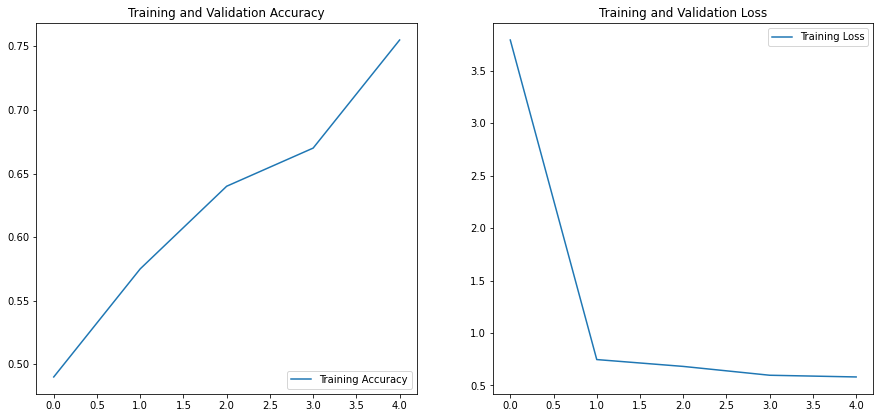

In [ ]:
# Kurva akurasi training
# membuat variabel tiap kategori matrics hasil training, baik data training ataupun validasi
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']

# membuat range epoch untuk X axis
epochs_range = range(epoch)

plt.figure(figsize=(15, 15))                                                                  # setup ukuran gambar
plt.subplot(2, 2, 1)                                                                          # subplot posisi pertama
plt.plot(epochs_range, acc, label='Training Accuracy')                                        # line chart training accuracy
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')                                  # line chart validation accuracy
plt.legend(loc='lower right')                                                                 # lokasi legend
plt.title('Training and Validation Accuracy')                                                 # judul chart

plt.subplot(2, 2, 2)                                                                          # sublplot posisi pertama
plt.plot(epochs_range, loss, label='Training Loss')                                           # linechart training loss
# plt.plot(epochs_range, val_loss, label='Validation Loss')                                     # linechart validation loss
plt.legend(loc='upper right')                                                                 # posisi legend
plt.title('Training and Validation Loss')                                                     # judul chart
plt.show()

In [ ]:
loss,accuracy = model.evaluate(x_train,y_train, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  0.7649999856948853
Model loss     :  0.614957332611084


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  0.5
Model loss     :  0.6440788507461548


In [ ]:
pred_ann = model.predict(x_train)
pred_ann = np.argmax(pred_ann, axis=-1) 
print(classification_report(y_train,pred_ann, target_names=le.classes_))

                precision    recall  f1-score   support

Sore,CB,Matang       0.94      0.56      0.71       200
Sore,CB,Mentah       0.69      0.96      0.80       200

      accuracy                           0.77       400
     macro avg       0.82      0.76      0.76       400
  weighted avg       0.82      0.77      0.76       400



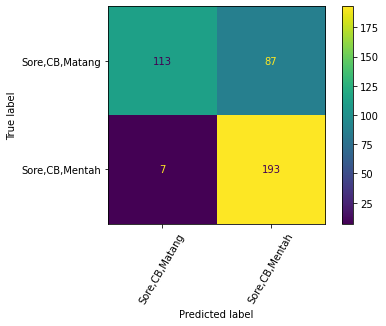

In [ ]:
cm = confusion_matrix(y_train, pred_ann)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.xticks(rotation=60)
plt.show() 

In [ ]:
pred_ann = model.predict(x_test)
pred_ann = np.argmax(pred_ann, axis=-1) 
print(classification_report(y_test,pred_ann, target_names=le.classes_))

                precision    recall  f1-score   support

Sore,CB,Matang       0.00      0.00      0.00        20
Sore,CB,Mentah       0.50      1.00      0.67        20

      accuracy                           0.50        40
     macro avg       0.25      0.50      0.33        40
  weighted avg       0.25      0.50      0.33        40



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


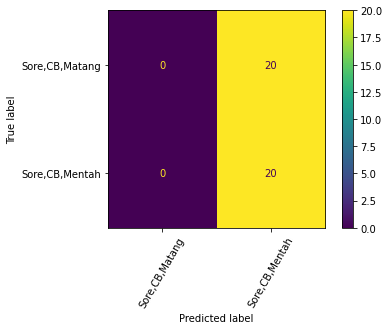

In [ ]:
cm = confusion_matrix(y_test, pred_ann)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.xticks(rotation=60)
plt.show() 

In [ ]:
print(opt[3])
train_images,test_images,train_labels,test_labels,ori_train_images,ori_test_images,ori_train_labels,ori_test_labels,train_fe_df,test_fe_df = generate_data(opt[3],9)

Sore,CTB


100%|██████████| 8/8 [00:00<00:00, 26.71it/s]


Original train data       : 20
Original test data        : 2
Augmentation I train data : 40
Augmentation I test data  : 4


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Augmentation II train data : 400
Augmentation II test data  : 40


In [ ]:
train_fe_df

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red
0,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",128.317343,131.859461,136.035422,7.395886,6.719392,6.571074
1,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",128.317343,131.859461,136.035422,7.395886,6.719392,6.571074
2,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",127.703167,131.589814,134.734088,6.638900,6.422421,7.640021
3,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",127.703167,131.589814,134.734088,6.638900,6.422421,7.640021
4,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",129.221951,133.512441,134.181902,7.550061,6.982620,6.999040
5,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",129.221951,133.512441,134.181902,7.550061,6.982620,6.999040
6,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",125.604010,126.490902,129.013137,6.813387,6.744268,7.212101
7,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",125.604010,126.490902,129.013137,6.813387,6.744268,7.212101
8,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",135.120196,135.350431,139.796235,6.630661,7.282020,8.196079
9,"Dataset 2 - Train Group/Sore,CTB,Matang/202107...",135.120196,135.350431,139.796235,6.630661,7.282020,8.196079


In [ ]:
test_fe_df

,Filename,Mean Blue,Mean Green,Mean Red,Std. Blue,Std. Green,Std. Red
0,Dataset 2 - Test Tunggal/SCTB+.jpg,127.781686,129.787696,132.139245,11.577245,9.714088,8.853548
1,Dataset 2 - Test Tunggal/SCTB+.jpg,127.781686,129.787696,132.139245,11.577245,9.714088,8.853548
2,Dataset 2 - Test Tunggal/SCTB-.jpg,131.111137,131.575598,131.264529,15.592619,13.124736,14.816042
3,Dataset 2 - Test Tunggal/SCTB-.jpg,131.111137,131.575598,131.264529,15.592619,13.124736,14.816042


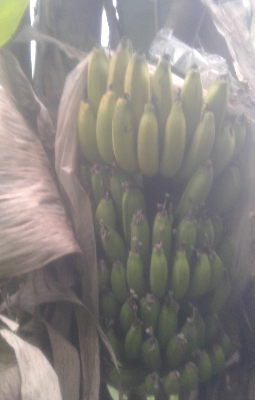

In [ ]:
imshow(train_images[0])

In [ ]:
le = LabelEncoder()
x_train = np.array(train_images)/255
y_train = le.fit_transform(train_labels)
x_test = np.array(test_images)/255
y_test = le.fit_transform(test_labels)
le.classes_

array(['Sore,CTB,Matang', 'Sore,CTB,Mentah'], dtype='<U15')

In [ ]:
model = Sequential([Flatten(input_shape = [default_size[1], default_size[0], 3]),
Dense(300, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(100, activation = 'relu' ),
Dense(2, activation = 'softmax' )])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 306000)            0         
                                                                 
 dense_15 (Dense)            (None, 300)               91800300  
                                                                 
 dense_16 (Dense)            (None, 100)               30100     
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dense_18 (Dense)            (None, 100)               10100     
                                                                 
 dense_19 (Dense)            (None, 2)                 202       
                                                                 
Total params: 91,850,802
Trainable params: 91,850,802


In [ ]:
# compile model
model.compile(loss = 'sparse_categorical_crossentropy',\
    optimizer = 'sgd',\
    metrics = ['accuracy'])

In [ ]:
# training model
epoch = 5

history = model.fit(x_train,
                    y_train,
                    epochs = epoch,
                    # validation_split=0.5
                )

Epoch 1/5
13/13 [==============================] - 1s 31ms/step - loss: 3.3056 - accuracy: 0.4850
Epoch 2/5
13/13 [==============================] - 0s 29ms/step - loss: 0.6992 - accuracy: 0.4900
Epoch 3/5
13/13 [==============================] - 0s 28ms/step - loss: 0.7069 - accuracy: 0.4775
Epoch 4/5
13/13 [==============================] - 0s 29ms/step - loss: 0.6974 - accuracy: 0.5450
Epoch 5/5
13/13 [==============================] - 0s 28ms/step - loss: 0.6641 - accuracy: 0.5575


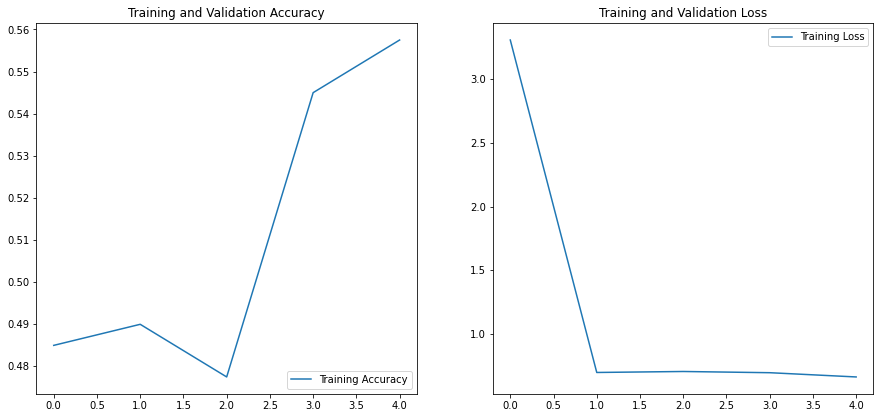

In [ ]:
# Kurva akurasi training
# membuat variabel tiap kategori matrics hasil training, baik data training ataupun validasi
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']

# membuat range epoch untuk X axis
epochs_range = range(epoch)

plt.figure(figsize=(15, 15))                                                                  # setup ukuran gambar
plt.subplot(2, 2, 1)                                                                          # subplot posisi pertama
plt.plot(epochs_range, acc, label='Training Accuracy')                                        # line chart training accuracy
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')                                  # line chart validation accuracy
plt.legend(loc='lower right')                                                                 # lokasi legend
plt.title('Training and Validation Accuracy')                                                 # judul chart

plt.subplot(2, 2, 2)                                                                          # sublplot posisi pertama
plt.plot(epochs_range, loss, label='Training Loss')                                           # linechart training loss
# plt.plot(epochs_range, val_loss, label='Validation Loss')                                     # linechart validation loss
plt.legend(loc='upper right')                                                                 # posisi legend
plt.title('Training and Validation Loss')                                                     # judul chart
plt.show()

In [ ]:
loss,accuracy = model.evaluate(x_train,y_train, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  0.5149999856948853
Model loss     :  0.665681004524231


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test, verbose=0)                                                   # mengevaluasi model secara keseluruhan berdasarkan loss dan accuracy
print('Model accuracy : ',accuracy)
print('Model loss     : ',loss)

Model accuracy :  0.5
Model loss     :  0.73668372631073


In [ ]:
pred_ann = model.predict(x_train)
pred_ann = np.argmax(pred_ann, axis=-1) 
print(classification_report(y_train,pred_ann, target_names=le.classes_))

                 precision    recall  f1-score   support

Sore,CTB,Matang       0.51      1.00      0.67       200
Sore,CTB,Mentah       1.00      0.03      0.06       200

       accuracy                           0.52       400
      macro avg       0.75      0.52      0.37       400
   weighted avg       0.75      0.52      0.37       400



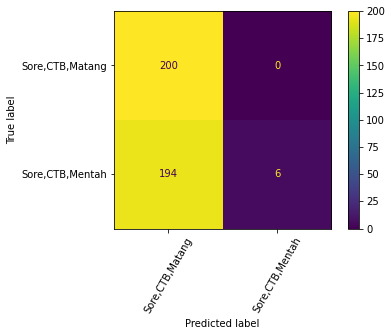

In [ ]:
cm = confusion_matrix(y_train, pred_ann)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.xticks(rotation=60)
plt.show() 

In [ ]:
pred_ann = model.predict(x_test)
pred_ann = np.argmax(pred_ann, axis=-1) 
print(classification_report(y_test,pred_ann, target_names=le.classes_))

                 precision    recall  f1-score   support

Sore,CTB,Matang       0.50      1.00      0.67        20
Sore,CTB,Mentah       0.00      0.00      0.00        20

       accuracy                           0.50        40
      macro avg       0.25      0.50      0.33        40
   weighted avg       0.25      0.50      0.33        40



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


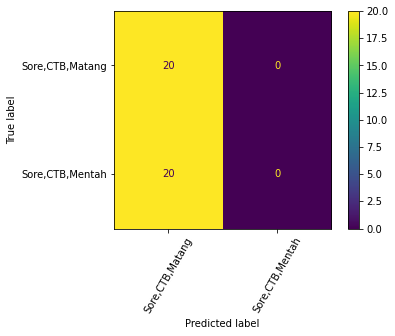

In [ ]:
cm = confusion_matrix(y_test, pred_ann)                                                                  # membuat confusion matrix data test
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)                              # membuat fungsi tampilan confusion matrix
disp.plot()                                                                                                 # membuat plot confusion matrix
plt.xticks(rotation=60)
plt.show() 